In [1]:
import matplotlib

import matplotlib.font_manager as fm

font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font_name = fm.FontProperties(fname = font_location).get_name()

matplotlib.rc('font',family = font_name)

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas_profiling
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [14]:
# 데이터 불러오기
df_raw=pd.read_csv("BOSTON_HOUSING.csv", engine="python", encoding="cp949")
df_raw.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063
std,9.197104,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000
50%,21.200001,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000
75%,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999
max,50.000000,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001


In [4]:
# 가설: 택스가 높으면 집값이 떨어진다.
# TAX를 50%를 기준으로 구분
# 연령대 변수 Generation 생성
df_raw['TAX_50%'] = 0

bins = [0,330,711]
labels = ["하위50%","상위50%"]

df_raw['TAX_50%'] = pd.cut(df_raw['TAX'], bins, labels = labels)


print(df_raw)

          MEDV     CRIM    ZN  INDUS  CHAS    NOX     RM        AGE     DIS  \
0    24.000000  0.00632  18.0   2.31     0  0.538  6.575  65.199997  4.0900   
1    21.600000  0.02731   0.0   7.07     0  0.469  6.421  78.900002  4.9671   
2    34.700001  0.02729   0.0   7.07     0  0.469  7.185  61.099998  4.9671   
3    33.400002  0.03237   0.0   2.18     0  0.458  6.998  45.799999  6.0622   
4    36.200001  0.06905   0.0   2.18     0  0.458  7.147  54.200001  6.0622   
..         ...      ...   ...    ...   ...    ...    ...        ...     ...   
501  22.400000  0.06263   0.0  11.93     0  0.573  6.593  69.099998  2.4786   
502  20.600000  0.04527   0.0  11.93     0  0.573  6.120  76.699997  2.2875   
503  23.900000  0.06076   0.0  11.93     0  0.573  6.976  91.000000  2.1675   
504  22.000000  0.10959   0.0  11.93     0  0.573  6.794  89.300003  2.3889   
505  11.900000  0.04741   0.0  11.93     0  0.573  6.030  80.800003  2.5050   

     RAD  TAX    PTRATIO           B  LSTAT TAX_50%

In [19]:
# 파생변수 만들기
# TAX를 500을 기준으로 구분
# df_raw['TAX500'] = df_raw.TAX[df_raw['TAX']<500]
bins = [0,250,500, 711]
labels = ["TWO", "FIVE", "SEVEN"]


df_raw['CTAX'] = pd.cut(df_raw['TAX'], bins, labels = labels)


In [20]:
df_raw = df_raw.join(pd.get_dummies(df_raw['CTAX']))

In [21]:
df_raw.drop('CTAX', axis = 1, inplace = True)


In [12]:
df_raw.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TWO,FIVE,SEVEN
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063,0.136364,0.592885,0.270751
std,9.197104,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062,0.343514,0.491783,0.444787
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,0.000000,0.000000,0.000000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,0.000000,0.000000,0.000000
50%,21.200001,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,0.000000,1.000000,0.000000
75%,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,0.000000,1.000000,1.000000
max,50.000000,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001,1.000000,1.000000,1.000000


In [ ]:
CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+FIVE+SEVEN+PTRATIO+B+LSTAT

In [ ]:
# 가설: 택스가 높으면 집값이 떨어진다.
# TAX를 50%를 기준으로 구분
# 연령대 변수 Generation 생성


bins = [0,250,500]
labels = ["250까지","500까지"]

df_raw['TAX_5'] = pd.cut(df_raw['TAX'], bins, labels = labels)


print(df_raw)

In [ ]:
df_raw['TAX_50%'].describe()
df_raw[(df_raw['TAX']>=330)]

In [ ]:
# 파생변수 만들기: 비소맹업/

In [ ]:
##### 2SAMPLE T TEST
from scipy.stats import shapiro
# 정규성 => 둘 다 정규성을 만족한다.
a=shapiro(df_raw['MEDV'][(df_raw["TAX_50%"]=="상위50%")])
b=shapiro(df_raw['MEDV'][(df_raw["TAX_50%"]=="하위50%")])
print(a,b)

In [ ]:
# 등분산성 => 등분산성을 만족한다.
from scipy import stats
from scipy.stats import levene
c=stats.levene(df_raw['MEDV'][(df_raw["TAX_50%"]=="상위50%")], df_raw['MEDV'][(df_raw["TAX_50%"]=="하위50%")])
print(c)

In [ ]:
# 결론: 유의수준 1%에서 재산세율이 다른 지역 간에 집값에 차이가 있다.
t_result=stats.ttest_ind(df_raw['MEDV'][(df_raw["TAX_50%"]=="상위50%")], df_raw['MEDV'][(df_raw["TAX_50%"]=="하위50%")])
t, p=t_result.statistic.round(3), t_result.pvalue.round(3)
print(t,p)

In [ ]:
# 이제 그 차이가 양인지, 음인지 살펴보자

In [ ]:
# 변수 설명 (506개 관측치)
# MEDV 주택가격(중앙값, 천 달러 단위)
#0 CRIM 타운별 1인당 범죄율
#1 ZN 25,000 스퀘어 피트를 넘는 주거지 비율
#2 INDUS 타운별 비소매업 면적 비율
#3 CHAS 찰스 강의 경계에 위치한 경우(1-조망)
#4 NOX 일산화질소 농도
#5 RM 주거당 평균 방 수
#6 AGE 1940년 이전에 지어진 노후 건물 비율
#7 DIS 5개 보스턴 직업센터까지의 거리
#8 RAD 방사형 고속도로까지의 거리
#9 TAX 만 달러 당 재산세율
#10 PTRATIO 타운별 학생당 교사 비율
#11 B 흑인 인구 비율
#12 LSTAT 저소득층 비율

In [ ]:
#Each record in the database describes a Boston suburb or town. 
#The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970.  
1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to ﬁve Boston employment centers 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per $10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in $1000s.

In [ ]:
# 분석하고자 하는 방향, 주제를 선정하고 예상 목표를 기술합니다.
# 분석 방향: 주거지의 가격에 영향을 미치는 요소를 자연 환경적 요소와 사회 환경적 요소로 구분하자.
# 분석 주제: 집 값을 결정하는 가장 큰 요인은 무엇일까?

In [ ]:
# 결측치 확인 => 결측치 없음
df_raw.isnull().sum()

In [ ]:
# 이상치 확인

df_raw.boxplot(["MEDV", "ZN", "INDUS", "AGE", "PTRATIO", "LSTAT"], figsize=(10, 4))


In [ ]:
### 집값, 주거지 비율, 학생당 교사 비율, 저소득충 비율에서 이상치가 존재한다.
#### => 각각 상한과 하한으로 대체한다.

In [ ]:
df_raw.boxplot(["TAX", "B"], figsize=(10, 4))

In [ ]:
### 흑인 인구 비율에서 이상치가 존재한다.
#### => 하한으로 대체한다.

In [ ]:
df_raw.boxplot(["CRIM", "NOX", "RM", "DIS", "RAD"], figsize=(10, 4))

In [ ]:
### 범죄율, 강 조망, 주거당 평균 객실 수, 중심지 접근 거리에 이상치가 존재한다.
#### 각각 상한과 하한으로 대체한다.

In [ ]:
# 모두 연속형 데이터이므로 히스토그램으로 분포를 확인한다.
df_raw[["MEDV", "ZN", "INDUS", "AGE"]].hist(figsize=(10,5))

In [ ]:
df_raw[["PTRATIO", "LSTAT","TAX", "B"]].hist(figsize=(10,5))

In [ ]:
df_raw[["CRIM","NOX", "RM", "DIS"]].hist(figsize=(10,5))

In [ ]:
df_raw[["RAD"]].hist(figsize=(10,5))

In [ ]:
df_raw[["TAX"]].hist(figsize=(10,5))

In [ ]:
# plt.figure(figsize=(15,8))
sns.pairplot(df_raw)
sns.set(font_scale=2)

In [ ]:
sns.heatmap(df_raw, cmap="Blues")

In [ ]:
# 잔차 검정
# 잔차의 독립성, 등분산성 확인
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")
# 잔차가 y=0을 기준으로 random하게 산포되어 있고, 정규성을 만족하지 않는다.
#등분산성도 만족하지 않는다.

In [ ]:
shapiro(reg_result.resid)
#더빈왓슨 검정 통계량을 볼 때 독립성도 만족하지 않는다.

In [ ]:
qqplot(reg_result.resid, line="q")
from statsmodels.stats.stattools import omni_normtest
omni_normtest(reg_result.resid, axis=0)
# 정규분포 직선(적색 선)을 중심으로 분포하고 검정통계량이 귀무가설을 채택하므로 정규분포를 따름

In [15]:
reg_model=smf.ols(formula="MEDV~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT", data=df_raw)
reg_result=reg_model.fit()
print(reg_result.summary())
# INDUS와 AGE는 유의하지 않음

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 08 Feb 2020   Prob (F-statistic):          6.72e-135
Time:                        23:25:51   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

In [17]:
# 다중공선성 확인 => 재산세율은 다중공선성이 높다. 어떤 변수와 선형 관계를 이루고 있는지 확인
df_raw_x=df_raw.drop(["MEDV"], axis=1)
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

,variable,VIF
4,CHAS,1.074
12,B,1.349
1,CRIM,1.792
11,PTRATIO,1.799
6,RM,1.934
2,ZN,2.299
13,LSTAT,2.941
7,AGE,3.101
8,DIS,3.956
3,INDUS,3.992


In [18]:
# INDUS와 AGE를 제외하고 회귀분석
reg_model2=smf.ols(formula="MEDV~CRIM+ZN+CHAS+NOX+RM+DIS+RAD+TAX+PTRATIO+B+LSTAT", data=df_raw)
reg_result2=reg_model2.fit()
print(reg_result2.summary())
# CHAS, NOX, RAD, B, LSTAT이 추가로 유의하지 않음

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Sat, 08 Feb 2020   Prob (F-statistic):          5.54e-137
Time:                        23:26:01   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3411      5.067      7.171      0.0

In [ ]:
# 다중공선성 확인
df_raw_x=df_raw.drop(["MEDV", "INDUS", "AGE"], axis=1)
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

In [ ]:
# 잔차 검정
# 잔차의 독립성, 등분산성 확인
plt.scatter(reg_result2.fittedvalues, reg_result2.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")
# 잔차가 y=0을 기준으로 random하게 산포되어 있고, 정규성을 만족하지 않는다.
#등분산성도 만족하지 않는다.

In [ ]:
shapiro(reg_result2.resid)
#더빈왓슨 검정 통계량을 볼 때 독립성도 만족하지 않는다.

In [ ]:
qqplot(reg_result.resid, line="q")
from statsmodels.stats.stattools import omni_normtest
omni_normtest(reg_result.resid, axis=0)
# 정규분포 직선(적색 선)을 중심으로 분포하고 검정통계량이 귀무가설을 채택하므로 정규분포를 따름

In [ ]:
# 표준화 회귀계수를 이용한 변수 중요도 확인
scaler=StandardScaler()
cols=df_raw_x.columns
np_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(np_scaled, columns=cols)
df_scaled["MEDV"]=df_raw["MEDV"]
reg_model_scaled=smf.ols(formula="MEDV~CRIM+ZN+CHAS+NOX+RM+DIS+RAD+TAX+PTRATIO+B+LSTAT", data=df_scaled)
reg_result_scaled=reg_model_scaled.fit()
print(reg_result_scaled.summary())

In [ ]:
# 표준화 회귀계수 산출
df_reg_coef_std=pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, index=selected_cols)
df_reg_coef_std.plot.barh(y="Coef", legend=False)

In [ ]:
#후진제거법
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
df_raw_x=df_raw.drop(["MEDV", "TAX_50%"], axis=1)
df_raw_y=df_raw["MEDV"]
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=11).fit(df_raw_x, df_raw_y)
selected_cols=df_raw_x.columns[rfe.support_]
removed_cols=df_raw_x.columns[~rfe.support_]

print("selected variables: {}".format(selected_cols))
print("removed variables: {}".format(removed_cols))

In [ ]:
rfe_reg_model=smf.ols(formula="MEDV~CRIM+ZN+CHAS+NOX+RM+DIS+RAD+TAX+PTRATIO+B+LSTAT", data=df_raw)
rfe_reg_result=rfe_reg_model.fit()
print(rfe_reg_result.summary())

In [ ]:
df_raw_x_rfe=df_raw_x[selected_cols]
df_raw_x_rfe_const=add_constant(df_raw_x_rfe)

df_rfe_vif=pd.DataFrame()
df_rfe_vif["variable"]=df_raw_x_rfe_const.columns
df_rfe_vif["VIF"]=[variance_inflation_factor(df_raw_x_rfe_const.values, i) for i in range(df_raw_x_rfe_const.shape[1])]
df_rfe_vif.sort_values("VIF", inplace=True)
df_rfe_vif.round(3)

In [ ]:
reg_model4=smf.ols(formula="MEDV~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+FIVE+SEVEN+PTRATIO+B+LSTAT", data=df_raw)
reg_result4=reg_model4.fit()
print(reg_result4.summary())
# INDUS와 AGE는 유의하지 않음

In [23]:
# 표준화 회귀계수를 이용한 변수 중요도 확인
df_raw_x=df_raw.drop(["MEDV"], axis=1)
scaler=StandardScaler()
cols=df_raw_x.columns
np_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(np_scaled, columns=cols)
df_scaled["MEDV"]=df_raw["MEDV"]
reg_model_scaled=smf.ols(formula="MEDV~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+FIVE+SEVEN+PTRATIO+B+LSTAT", data=df_scaled)
reg_result_scaled=reg_model_scaled.fit()
print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     101.6
Date:                Sat, 08 Feb 2020   Prob (F-statistic):          5.74e-135
Time:                        23:26:38   Log-Likelihood:                -1496.2
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     491   BIC:                             3086.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.5328      0.210    107.259      0.0

In [22]:
# 다중공선성 확인
df_raw_x=df_raw.drop(["MEDV", "INDUS", "AGE", "TWO", "TAX"], axis=1)
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

,variable,VIF
3,CHAS,1.055
9,B,1.340
1,CRIM,1.789
8,PTRATIO,1.790
5,RM,1.820
2,ZN,2.251
11,FIVE,2.312
10,LSTAT,2.593
6,DIS,3.490
4,NOX,3.613


In [49]:
# 표준화 회귀계수를 이용한 변수 중요도 확인
scaler=StandardScaler()
cols=df_raw_x.columns
np_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(np_scaled, columns=cols)
df_scaled["MEDV"]=df_raw["MEDV"]
reg_model_scaled=smf.ols(formula="MEDV~CRIM+ZN+CHAS+NOX+RM+DIS+RAD+PTRATIO+LSTAT+FIVE+SEVEN", data=df_scaled)
reg_result_scaled=reg_model_scaled.fit()
print(reg_result_scaled.summary())


                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     125.6
Date:                Sun, 09 Feb 2020   Prob (F-statistic):          2.40e-135
Time:                        00:45:45   Log-Likelihood:                -1502.7
No. Observations:                 506   AIC:                             3029.
Df Residuals:                     494   BIC:                             3080.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.5328      0.212    106.199      0.0

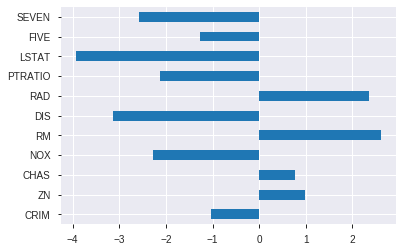

In [50]:
df_a_x=df_raw.drop(["MEDV", "TWO", "TAX", "AGE","B", "INDUS"], axis=1)
selected_cols=df_a_x.columns
df_reg_coef=pd.DataFrame({"Coef": reg_result_scaled.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y="Coef", legend=False)